# Calculating Bias corrected SubX input for SubX-IFLOOD

This notebook demonstrates how to calculate bias correct SubX input for the SubX-IFLOOD system
The steps are:
1. Calculate the observed climatologies 
2. Calculate the SubX model climatology
3. Calcluate the SubX model anomalies as the full field minus the climatology
4. Calculate the Bias Corrected full field data for input into the SubX-IFLOOD system as the SubX model anomalies + the observed climatology

In [1]:
from dask.distributed import Client, progress
client = Client(n_workers=8, memory_limit='20GB')
client

Client Scheduler: tcp://127.0.0.1:42119 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 130.25 GB


In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import dask
import pandas as pd

## Data

### SubX
The SubX data from the EMC-GEFS model, located on the COLA Servers in: 
```/shared/subx/hindcast/<varname>/daily/full/EMC-GEFS/```
where varname refers to the variable name (e.g. uas_10m, vas_10m, pslmsl)

### Verification (i.e. Truth)
The verification data is the NCEP Reanalysis data regridded by Ehsan, located in:
```/shared/SWFluxCorr/SubX/Ehsan/verif/<varname>/daily/regrid/```
where varname refers to the variable name (e.g. uas, vas, pslmsl)

For this example, we will use pslmsl

## 1. Calculate Observed Climatology

Set path and filename

In [3]:
varname='psl'
level='msl'
verif='NCEPR1-REAN'

path_verif='/shared/SWFluxCorr/SubX/Ehsan/verif/'+varname+level+'/daily/regrid/'
fname_verif=path_verif+varname+level+'_'+verif+'_*daily.nc'
fname_verif

'/shared/SWFluxCorr/SubX/Ehsan/verif/pslmsl/daily/regrid/pslmsl_NCEPR1-REAN_*daily.nc'

Read Data

In [4]:
ds_verif=xr.open_mfdataset(fname_verif,combine='by_coords')
ds_verif

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 360, time: 6940)
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2017-12-31
Data variables:
    pslmsl   (time, lat, lon) float32 dask.array<chunksize=(365, 181, 360), meta=np.ndarray>
Attributes:
    title:         NCEPR1 pslmsl on SubX 1x1 deg grid for verifiation
    long_title:    NCEPR1 pslmsl on SubX 1x1 deg grid for verifiation
    comments:      
    institution:   NOAA/NCEP
    source:        NOAA/ESRL/PSD
    CreationDate:  2018/06/28 18:57:20
    CreatedBy:     eerfani
    MatlabSource:  calc_pslmsl_verif

First step in calculating climatology is to take average for each day over all years

In [5]:
ds_verifclimo = ds_verif.groupby('time.dayofyear').mean('time')
ds_verifclimo=ds_verifclimo.chunk({'dayofyear':-1})
ds_verifclimo

<xarray.Dataset>
Dimensions:    (dayofyear: 366, lat: 181, lon: 360)
Coordinates:
  * lat        (lat) float32 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon        (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Data variables:
    pslmsl     (dayofyear, lat, lon) float32 dask.array<chunksize=(366, 181, 360), meta=np.ndarray>

Second step in calculating climatology is to smooth the data using a triangular window (i.e. 2-passes of the smoother).  The smoothing must be applied so that it is period (i.e. Jan needs to know about Dec and Dec needs to know about Jan)

In [6]:
# Triangular smoother by smoothing twice (TODO: make a function)
for i in range(2):

    # Put end of Dec in beginning and first of Jan at end to make periodic
    ds_verif_climo_smooth= xr.concat([ds_verifclimo[varname+level][-15:],
                                      ds_verifclimo[varname+level],
                                      ds_verifclimo[varname+level][:15]],
                                     'dayofyear')

    # Smooth 
    ds_verif_climo_smooth = ds_verif_climo_smooth.rolling(dayofyear=31,
                                    center=True,
                                    min_periods=1).mean()
    # Drop periodic
    ds_verif_climo_smooth = ds_verif_climo_smooth.isel(dayofyear=slice(15, -15))
    
ds_verif_climo_smooth

<xarray.DataArray (dayofyear: 366, lat: 181, lon: 360)>
dask.array<getitem, shape=(366, 181, 360), dtype=float32, chunksize=(366, 181, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon        (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366

Plot to check data

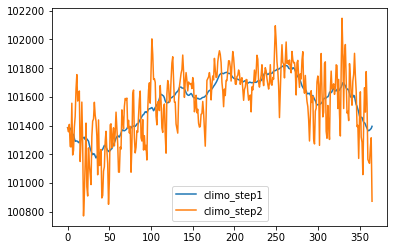

In [7]:
plt.plot(ds_verif_climo_smooth.sel(lon='300',lat='40',method='nearest'))
plt.plot(ds_verifclimo.sel(lon='300',lat='40',method='nearest')[varname+level])
plt.legend(['climo_step1','climo_step2'])

## 2. Calculate the SubX Model Climatology

Set path and filename

In [8]:
model='EMC-GEFS'
path_subx='/shared/subx/hindcast/'+varname+level+'/daily/full/'+model+'/'
fname_subx=path_subx+varname+'_'+level+'_'+model+'_*.emean.daily.nc'
fname_subx

'/shared/subx/hindcast/pslmsl/daily/full/EMC-GEFS/psl_msl_EMC-GEFS_*.emean.daily.nc'

Read SubX data

In [9]:
ds_subx=xr.open_mfdataset(fname_subx,parallel=True,combine='nested',concat_dim='init')
ds_subx

<xarray.Dataset>
Dimensions:  (init: 6209, lat: 181, lon: 360, time: 35)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01T12:00:00 ... 1960-02-04T12:00:00
  * lat      (lat) float32 90.0 89.0 88.0 87.0 86.0 ... -87.0 -88.0 -89.0 -90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Dimensions without coordinates: init
Data variables:
    psl      (init, time, lat, lon) float32 dask.array<chunksize=(1, 35, 181, 360), meta=np.ndarray>
Attributes:
    title:         SubX Ensemble Means
    long_title:    SubX Ensemble Means
    comments:      SubX project http://cola.gmu.edu/~kpegion/subx/
    institution:   IRI
    source:        SubX IRI
    CreationDate:  2018/06/23 02:57:04
    CreatedBy:     kpegion
    MatlabSource:

Time handing

In [10]:
ds_subx['time']=np.arange(0,35)
ds_subx['init']=pd.date_range(start='1999-01-01',end='2015-12-31',freq='D')
ds_subx['init']=pd.to_datetime(ds_subx['init'].dt.strftime('%Y%m%d 00:00'))
ds_subx

<xarray.Dataset>
Dimensions:  (init: 6209, lat: 181, lon: 360, time: 35)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 25 26 27 28 29 30 31 32 33 34
  * lat      (lat) float32 90.0 89.0 88.0 87.0 86.0 ... -87.0 -88.0 -89.0 -90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * init     (init) datetime64[ns] 1999-01-01 1999-01-02 ... 2015-12-31
Data variables:
    psl      (init, time, lat, lon) float32 dask.array<chunksize=(1, 35, 181, 360), meta=np.ndarray>
Attributes:
    title:         SubX Ensemble Means
    long_title:    SubX Ensemble Means
    comments:      SubX project http://cola.gmu.edu/~kpegion/subx/
    institution:   IRI
    source:        SubX IRI
    CreationDate:  2018/06/23 02:57:04
    CreatedBy:     kpegion
    MatlabSource:

First step in calculating climatology is to take average for each day over all years

In [11]:
ds_subxclimo = ds_subx.groupby('init.dayofyear').mean('init')
ds_subxclimo=ds_subxclimo.chunk({'dayofyear':-1})
ds_subxclimo

<xarray.Dataset>
Dimensions:    (dayofyear: 366, lat: 181, lon: 360, time: 35)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34
  * lat        (lat) float32 90.0 89.0 88.0 87.0 ... -87.0 -88.0 -89.0 -90.0
  * lon        (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Data variables:
    psl        (dayofyear, time, lat, lon) float32 dask.array<chunksize=(366, 35, 181, 360), meta=np.ndarray>

Second step in calculating climatology is to smooth the data using a triangular window (i.e. 2-passes of the smoother).  The smoothing must be applied so that it is period (i.e. Jan needs to know about Dec and Dec needs to know about Jan)

In [12]:
# Triangular smoother by smoothing twice
for i in range(2):

    # Put end of Dec in beginning and first of Jan at end to make periodic
    ds_subx_climo_smooth= xr.concat([ds_subxclimo[varname][-15:],
                                      ds_subxclimo[varname],
                                      ds_subxclimo[varname][:15]],
                                     'dayofyear')

    # Smooth 
    ds_subx_climo_smooth = ds_subx_climo_smooth.rolling(dayofyear=31,
                                    center=True,
                                    min_periods=1).mean()
    # Drop periodic
    ds_subx_climo_smooth = ds_subx_climo_smooth.isel(dayofyear=slice(15, -15))
    
ds_subx_climo_smooth

<xarray.DataArray (dayofyear: 366, time: 35, lat: 181, lon: 360)>
dask.array<getitem, shape=(366, 35, 181, 360), dtype=float32, chunksize=(366, 35, 181, 360), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34
  * lat        (lat) float32 90.0 89.0 88.0 87.0 ... -87.0 -88.0 -89.0 -90.0
  * lon        (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366

## 3. Calculate SubX Model Anomalies

Calculate anomalies by subtracting climatology

In [13]:
ds_subx_anoms=ds_subx.groupby('init.dayofyear')-ds_subxclimo
ds_subx_anoms

<xarray.Dataset>
Dimensions:    (init: 6209, lat: 181, lon: 360, time: 35)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34
  * lat        (lat) float32 90.0 89.0 88.0 87.0 ... -87.0 -88.0 -89.0 -90.0
  * lon        (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * init       (init) datetime64[ns] 1999-01-01 1999-01-02 ... 2015-12-31
    dayofyear  (init) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
Data variables:
    psl        (init, time, lat, lon) float32 dask.array<chunksize=(1, 35, 181, 360), meta=np.ndarray>

## 4. Calculate the Bias Corrected full field data for input into the SubX-IFLOOD system

In [17]:
inits=['2005-08-17']
opath='/scratch/kpegion/'
nleads=len(ds_subx_anoms['time'])
print(nleads)

for init in inits:

    # Extract the forecast for this initializatoin
    this_fcst=ds_subx_anoms.sel(init=init)
    
    # Find the observed climo data that matches this fcst
    this_obsclimo = ds_verif_climo_smooth.sel(dayofyear=slice(this_fcst['init.dayofyear'],
                                                           this_fcst['init.dayofyear']+nleads-1))
 
    # Change time dimensions of this_climo to match this_forecast
    this_obsclimo=this_obsclimo.rename({'dayofyear':'time'})
    this_obsclimo['time']=np.arange(0,nleads)

    print(this_fcst)
    print(this_obsclimo)
    
    # Calculate the bias corrected forecast (obs_climo + model_anoms)
    ds_biascorrected=(this_fcst+this_obsclimo).drop('dayofyear')
    ds_biascorrected

35
<xarray.Dataset>
Dimensions:    (lat: 181, lon: 360, time: 35)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34
  * lat        (lat) float32 90.0 89.0 88.0 87.0 ... -87.0 -88.0 -89.0 -90.0
  * lon        (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
    init       datetime64[ns] 2005-08-17
    dayofyear  int64 229
Data variables:
    psl        (time, lat, lon) float32 dask.array<chunksize=(35, 181, 360), meta=np.ndarray>
<xarray.DataArray (time: 35, lat: 181, lon: 360)>
dask.array<getitem, shape=(35, 181, 360), dtype=float32, chunksize=(35, 181, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 25 26 27 28 29 30 31 32 33 34
<xarray.Dataset>
Dimensions:  (lat: 181, lon: 360, time: 35)
Coordinates:
  * lat      (lat) float6

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
